<a href="https://colab.research.google.com/github/tiskutis/Brolis/blob/main/Chemometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chemometrics is the science of extracting information from chemical systems by data-driven means. Chemometrics is inherently interdisciplinary, using methods frequently employed in core data-analytic disciplines such as multivariate statistics, applied mathematics, and computer science, in order to address problems in chemistry, biochemistry, medicine, biology and chemical engineering. 

In Brolis Sensor Technology, ultra-compact laser-based integrated sensor technology molecule-sensing is based on relation between near infrared absorption spectra measurements and target molecule concentration. In this task, we provide you a database of artificial near infrared absorption spectra of aqueous glucose solution with corresponding concentrations and two reference spectra of glucose 𝜀𝑔𝑙𝑢𝑐𝑜𝑠𝑒 and water 𝜀𝑤𝑎𝑡𝑒𝑟 separately. Assume that at every wavelength absorption’s 𝐴 relationship on reference spectra and concentration 𝑐 is described by function 

`𝐴 = 𝑎 + 𝑑 (𝑐*𝜀𝑔𝑙𝑢𝑐𝑜𝑠𝑒 +(1−𝑐)*𝜀𝑤𝑎𝑡𝑒𝑟) + 𝑢`, 

where 𝑢 is random noise and 𝑎,𝑑,𝑐 are real numbers. Fit a model to the 10 spectra Sample_Gluc-xxx.h5 given in Data_prepared_syntetic.zip and estimate parameters 𝑎,𝑑,𝑐. Numbers in the file names are real concentrations. Evaluate concentration prediction accuracy using RMSE (root mean squared error) measure.

In [258]:
import pandas as pd
from pandas import Series
from google.colab import drive
from os.path import join
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
drive.mount('/content/drive/')

Reading reference spectra:

In [192]:
ref_spectra = pd.read_csv('/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic/Reference_spectra.csv')

In [261]:
ref_spectra.head()

,wavelength,glucose_absorptivity,water_absorptivity
0,2000,0.02,0.021852
1,2001,0.02,0.021761
2,2002,0.02,0.021671
3,2003,0.02,0.021580
4,2004,0.02,0.021489


Reading absorption spectra and extracting relevant information: wavelength, absorption and concentration:

In [194]:
path = '/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic'
filenames = [f for f in listdir(path) if f.endswith('.h5')]

In [195]:
files = []

for filename in filenames:

  file_info = {}

  with h5py.File(join(path, filename), "r") as f:

    a_group_key = list(f.keys())[0]
    group = f[a_group_key]

    file_info['absorbance'] = group['block0_values'][()]
    file_info['wavelength'] = group['block1_values'][()]
    file_info['concentration'] = abs(float(re.findall(r"[-+]?\d*\.\d+|\d+", filename)[0]))
    
    files.append(file_info)

I am going to construct a dataframe which consists wavelengths and all 10 provided spectra as well as reference spectra.
All measurements are in range of 2000-2400 nm so I take wavelenghts only from
the first measurement and then iterate over files to put extracted information into dictionary. This dictionary is then used to create a dataframe.

In [197]:
data = {'wavelength': files[0]['wavelength'].flatten()}

for file in files:
  concentration = file['concentration']
  key = f'absorbance c={concentration}'
  data[key] = file['absorbance'].flatten()

In [198]:
df = pd.DataFrame(data)

In [199]:
df = pd.merge(df, ref_spectra, on='wavelength')

In [200]:
df.shape

(401, 13)

In [202]:
df.head()

,wavelength,absorbance c=0.03,absorbance c=0.04,absorbance c=0.07,absorbance c=0.05,absorbance c=0.06,absorbance c=0.12,absorbance c=0.1,absorbance c=0.08,absorbance c=0.09,absorbance c=0.11,glucose_absorptivity,water_absorptivity
0,2000,0.001091,0.001085,0.001084,0.001094,0.001094,0.001080,0.001087,0.001081,0.001083,0.001079,0.02,0.021852
1,2001,0.001090,0.001078,0.001078,0.001087,0.001088,0.001081,0.001084,0.001084,0.001087,0.001080,0.02,0.021761
2,2002,0.001077,0.001083,0.001075,0.001071,0.001075,0.001076,0.001072,0.001090,0.001068,0.001071,0.02,0.021671
3,2003,0.001082,0.001074,0.001072,0.001080,0.001078,0.001073,0.001074,0.001075,0.001080,0.001075,0.02,0.021580
4,2004,0.001072,0.001075,0.001070,0.001067,0.001078,0.001068,0.001077,0.001067,0.001065,0.001065,0.02,0.021489


By using the dataframe above I took various concentrations and the provided equation 

`𝐴 = 𝑎 + 𝑑 (𝑐*𝜀𝑔𝑙𝑢𝑐𝑜𝑠𝑒 +(1−𝑐)*𝜀𝑤𝑎𝑡𝑒𝑟) + 𝑢`

and solved for a and d constants by hand (a approximately equal to 0.00012 and d approximately equal to 0.04). 

The next step is to fit linear regression model (because we have linear dependence shown in the equation) on our data and evaluate concentration prediction accuracy using RMSE. For that purpose I have to construct a new dataframe, where wavelength will be dropped, all absorption information is put into three columns (absorption spectrum A and two reference spectra) and concentration is put into target column.

In [223]:
dataframes = []

for column in df.columns:

  if 'absorbance' in column:
    
    target_concentration = re.findall(r"[-+]?\d*\.\d+|\d+", column)[0]
    temp_df = pd.DataFrame({'absorbance':df[column],
                            'glucose_absorptivity': df['glucose_absorptivity'],
                            'water_absorptivity': df['water_absorptivity'],
                            'concentration': target_concentration})
    
    dataframes.append(temp_df)

df_new = pd.concat(dataframes)

In [231]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

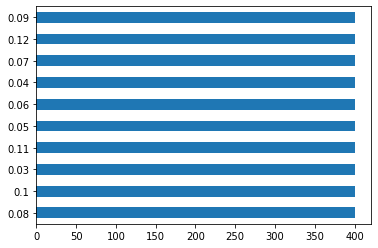

In [233]:
df_new.concentration.value_counts().plot(kind = 'barh')

Every concentration target value has 400 samples, so dataset is perfectly balanced. It is now ready to be split to train and test subsets and trained.

In [246]:
X = df_new.drop(['concentration'], axis=1)
y = df_new['concentration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [250]:
reg = LinearRegression().fit(X_train, y_train)

In [256]:
y_pred = reg.predict(X_test)

In [259]:
mean_squared_error(y_test, y_pred)

0.0005946196836121249

The RMSE is the square root of the variance of the residuals (differences between predicted and actual values). It indicates the absolute fit of the model to the data – how close the observed data points are to the model’s predicted values. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In this case real concentration values are of 10^-2 - 10^-1 order, so RMSE being of order 10^-4 indicates very good fit on the data.